In [14]:
import numpy as np
import os
import pandas as pd
import sys
import torch

from matplotlib import pyplot as plt
from tqdm import tqdm

project_dir = os.path.join(os.getcwd(),'..')
if project_dir not in sys.path:
    sys.path.append(project_dir)

In [16]:
from torch import nn
from VAE.nn import AnomalyDetector
from functools import reduce

class StethoscopeEncoder(nn.Module):
    def __init__(self, dropout=True) -> None:
        super(StethoscopeEncoder, self).__init__()

        self.encode = nn.Sequential(
            nn.Sequential(
                nn.Conv2d(1, 16, 3, padding=1),
                nn.BatchNorm2d(16, affine=True),
                *(nn.Dropout2d(0.2), nn.ReLU()) if dropout else (nn.ReLU(),),
                nn.MaxPool2d(3, stride=2, padding=1)
            ),
            nn.Sequential(
                nn.Conv2d(16, 32, (3, 5), padding=1), # (124,10) -> (122, 8)
                nn.BatchNorm2d(32, affine=True),
                *(nn.Dropout2d(0.2), nn.ReLU()) if dropout else (nn.ReLU(),),
                nn.MaxPool2d(3, stride=2, padding=1)
            ),
            nn.Sequential(
                nn.Conv2d(32, 36, (7, 3), padding=0), # (122, 8) -> (56, 2)
                nn.BatchNorm2d(36, affine=True),
                *(nn.Dropout2d(0.2), nn.ReLU()) if dropout else (nn.ReLU(),),
                nn.MaxPool2d(3, stride=2, padding=1)
            )
        )

    def forward(self, x):
        return self.encode(x)
    
class StethoscopeDecoder(nn.Module):
    def __init__(self) -> None:
        super(StethoscopeDecoder, self).__init__()

        self.decode = nn.Sequential(
            nn.Sequential(
                nn.Upsample(scale_factor=2),
                nn.ConvTranspose2d(36, 32, (7, 3), padding=0),
                nn.BatchNorm2d(32, affine=True),
                nn.ReLU()
            ),
            nn.Sequential(
                nn.Upsample(scale_factor=2),
                nn.ConvTranspose2d(32, 16, (3, 5), padding=1),
                nn.BatchNorm2d(16, affine=True),
                nn.ReLU()
            ),
            nn.Sequential(
                nn.Upsample(scale_factor=2),
                nn.Conv2d(16, 1, 3, padding=1)
            )
        )

    def forward(self, z):
        return self.decode(z)
    

class Model(nn.Module):
    def __init__(self, bottleneck=2, sigma=3) -> None:
        super(Model, self).__init__()

        self.encoder = self.__encode_path__()
        self.bottleneck = AnomalyDetector(
            in_features=128, out_features=bottleneck, sigma_anomaly=sigma)
        self.decoder = self.__decode_path__()
        

    def forward(self, x):
        z = self.encoder(x)
        z = self.bottleneck(z)
        x_ = self.decoder(z)
        return x_
    
    def __encode_path__(self):
        conv_encoder = StethoscopeEncoder()
        encoded_size = 36 * 28 * 1 # 36 channels, 28x1 image
        linear_encoder = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(encoded_size, 128),
            nn.BatchNorm1d(128, affine=True),
            nn.ReLU(),
        )

        return nn.Sequential(
            conv_encoder,
            nn.Flatten(),
            linear_encoder
        )
    
    def __decode_path__(self):
        encoded_shape = (36, 28, 1) # 36 channels, 28x1 image
        encoded_size = reduce(lambda x, y: x*y, encoded_shape)
        conv_decoder = StethoscopeDecoder()
        linear_decoder = nn.Sequential(
            nn.Linear(2, 128),
            nn.BatchNorm1d(128, affine=True),
            nn.ReLU(),
            nn.Linear(128, 36 * 28 * 1),
            nn.BatchNorm1d(36 * 28 * 1, affine=True),
            nn.ReLU(),
        )

        return nn.Sequential(
            linear_decoder,
            nn.Unflatten(1, encoded_shape),
            conv_decoder
        )

In [17]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

from torch.optim import Adam
from torch.nn.functional import mse_loss
from VAE.loss import SGVBL
import numpy as np

def weights(dataset):
    _, y = zip(*dataset)
    y = torch.tensor(y)

    count = torch.bincount(y)
    weights = 1. / np.array(count)
    weights /= weights.sum()

    return weights[y]

def train(model, train_dataset, batch_size, n_epochs, lr=1e-3, kl_weight=1, weighted_sampler=False, **kwargs):
    if weighted_sampler:
        sampler = torch.utils.data.WeightedRandomSampler(weights(train_dataset), len(train_dataset), replacement=True)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    else:
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.train()

    epoch_iterator = tqdm(
            range(n_epochs),
            leave=False,
            unit="epoch",
            postfix={"tls": "%.4f" % -1},
        )
    
    opt = Adam(model.parameters(), lr=lr)
    sgvbl = SGVBL(model, len(train_dataset), mle=mse_loss)
    for _ in epoch_iterator:
        epoch_loss = 0.
        for x, y in train_loader:
            x = x.to(device) 
            opt.zero_grad()
            x_hat = torch.tanh(model(x))
            loss = sgvbl(x, x_hat, y, kl_weight)
            epoch_loss += loss.detach().item()

            loss.backward()
            opt.step()

        epoch_iterator.set_postfix(tls="%.3f" % (epoch_loss/len(train_loader)))

    return model.eval().cpu()

In [18]:
import pytorch_lightning as pl

In [19]:
import pytorch_lightning as pl
from VAE.loss import SGVBL
from torch.nn.functional import mse_loss

class LightningModel(pl.LightningModule):
    def __init__(self, model: Model) -> None:
        super(LightningModel, self).__init__()
        self.model = model
        self.sgvbl = SGVBL(self.model, 1, mle=mse_loss)

    def training_step(self, batch, batch_idx) -> torch.Tensor:
        x, y = batch
        x_hat = torch.tanh(self.model(x))
        loss = self.sgvbl(x, x_hat, y, kl_weight=1)
        return loss
    
    def configure_optimizers(self) -> torch.optim.Optimizer:
        return torch.optim.Adam(self.model.parameters(), lr=1e-3)
    
        

AnomalyMNIST Dataset (Number of samples: 2200, Number of known anomalies: 100, Number of unknown anomalies: 100)


/tmp/ipykernel_28295/3914160115.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


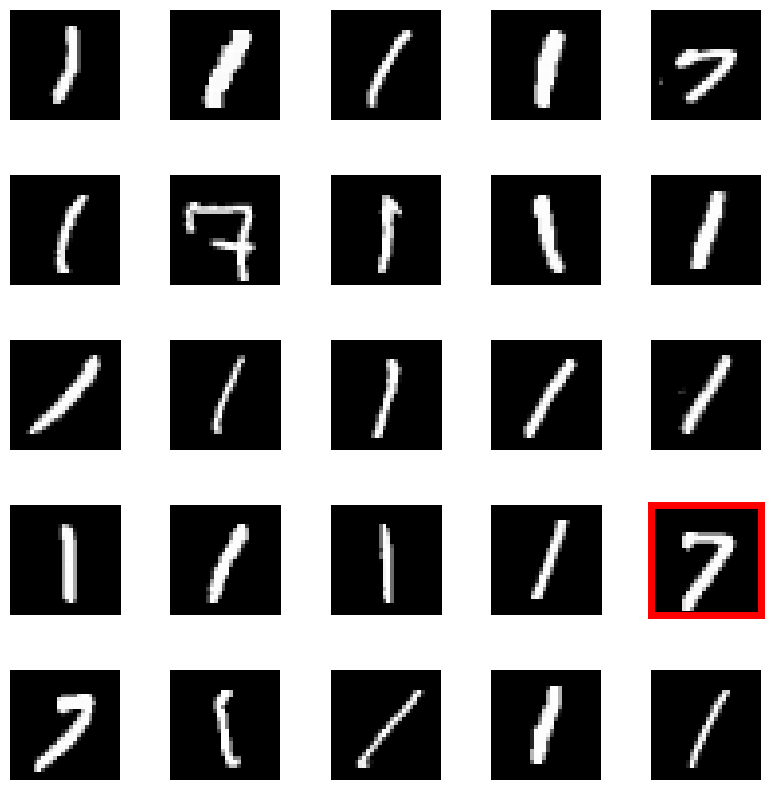

In [20]:
from dataset import AnomalyMNIST
from torchvision.transforms import Normalize,ToTensor, Compose

seed = 42
transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])

# dataset = AnomalyMNIST('data/', download=True, transform=transform, n_known_anomalies=512, pollution=0.25, seed=seed)
dataset = AnomalyMNIST('data/', download=True, transform=transform, n_normal_samples=2000, known_anomalies=0.05, pollution=0.05, seed=seed)
print(dataset)

fig = dataset.montage(5, 5, seed)
# fig.savefig('mnist_montage.png', dpi=300, bbox_inches='tight')
fig.show()


In [21]:
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset, batch_size=128, shuffle=True)

## Test

In [22]:
# TODO: Include the test set configuration in the AnoamlyMNIST class
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import Subset, DataLoader

test_dataset_full = MNIST('data/', train = False, download = True, transform = transform)
normal_idx = torch.where((test_dataset_full.targets == 1))[0]
anomaly_idx = torch.where((test_dataset_full.targets == 7))[0]
idx = torch.cat([normal_idx[:256], anomaly_idx[:256]]) # 512 samples!

test_dataset_full.targets = torch.ones_like(test_dataset_full.targets) * -1
test_dataset_full.targets[normal_idx] = 0
test_dataset_full.targets[anomaly_idx] = 1

x_test_set = Subset(test_dataset_full, idx)
test_loader =  DataLoader(x_test_set, 512, shuffle=False)

## Model

In [23]:
from ADeLEn.model import ADeLEn
from VAE.loss import SGVBL

adelen = ADeLEn((28, 28), [1, 32, 48], [1024, 256, 32], bottleneck=2, skip_connection=False)
model = LightningModel(adelen)

# # model = ADeLEn((28, 28), [1, 12, 32], [1024, 512, 128, 2], skip_connection=False)
# d = 2
# model = ADeLEn((28, 28), [1, 32, 48], [1024, 256, 32], bottleneck=d, skip_connection=False)
# from torch.nn.functional import mse_loss
# sgvbl = SGVBL(model, len(dataset), mle=mse_loss)

## Training

In [ ]:
model = train(model, dataset, 128, 50, 1e-3, 1, weighted_sampler=False)

In [24]:
trainer = pl.Trainer(max_epochs=50)
trainer.fit(model, train_loader)    

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ahguedes/Workspace/Anaconda/envs/ADeLEn/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | model | ADeLEn | 5.4 M  | train
1 | sgvbl | SGVBL  | 5.4 M  | train
-----------------------------------------
5.4 M     Trainable params
0         Non-trainable params
5.4 M     Total params
21.575   

Epoch 49: 100%|██████████| 18/18 [00:00<00:00, 31.88it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 18/18 [00:00<00:00, 23.80it/s, v_num=0]


## Test

In [33]:
X, y = zip(*dataset)
X = torch.stack(X)
y = torch.tensor(y)

normal = X[y == 0]
model.eval()
_ = model.model(normal).detach()
model.model.bottleneck.sigma.mean()

tensor(1.0782, grad_fn=<MeanBackward0>)

In [27]:
import numpy as np

def plot_latent(model, data, num_batches=100):
    fig = plt.figure(figsize=(5,5))
    with torch.no_grad():
        for i, (x, y) in enumerate(data):
            # x = x.to(device)
            z = model.bottleneck(model.encode_path(x))
            z = z.cpu().detach().numpy()
            y = y.cpu().detach().numpy()
            anomalies = np.where(y == 1)
            normal = np.where(y == 0)
            if i == 0:
                plt.scatter(z[normal, 0], z[normal, 1], c='r', alpha=.7, label='normal')
                plt.scatter(z[anomalies, 0], z[anomalies, 1], c='b', alpha=.7, label='anomalies')
            else:
                plt.scatter(z[normal, 0], z[normal, 1], c='r',alpha=.7)
                plt.scatter(z[anomalies, 0], z[anomalies, 1], c='b',alpha=.7)
           
            if i > num_batches:
                plt.legend()
                return
    plt.legend()
    return fig

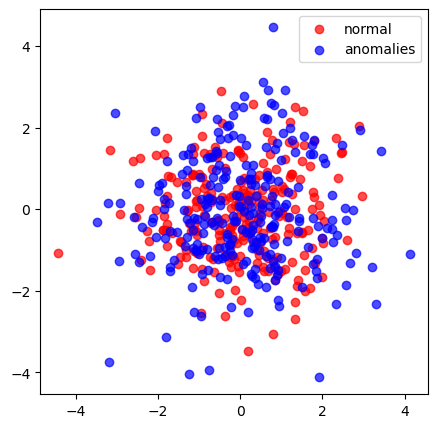

In [29]:
fig = plot_latent(model.model, test_loader, num_batches=25)

torch.Size([1, 1, 28, 28])


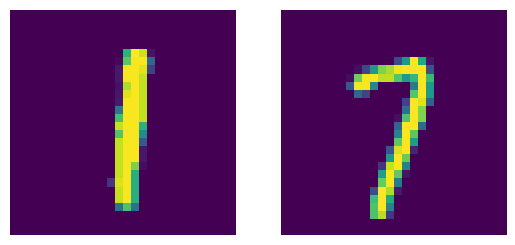

In [36]:
x, y = next(iter(test_loader))
x_0 = x[torch.argwhere(y==0).squeeze()[150]].unsqueeze(0)
x_1 = x[torch.argwhere(y==1).squeeze()[152]].unsqueeze(0)

print(x_0.shape)

plt.subplot(1,2,1)
plt.imshow(x_0[0,0])
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(x_1[0,0])
plt.axis('off')
model.eval()
z_0, z_1 = [], []
for i in range(100):
    z_0.append(model.model.bottleneck(model.model.encode_path(x_0)).detach().cpu())
    z_1.append(model.model.bottleneck(model.model.encode_path(x_1)).detach().cpu())

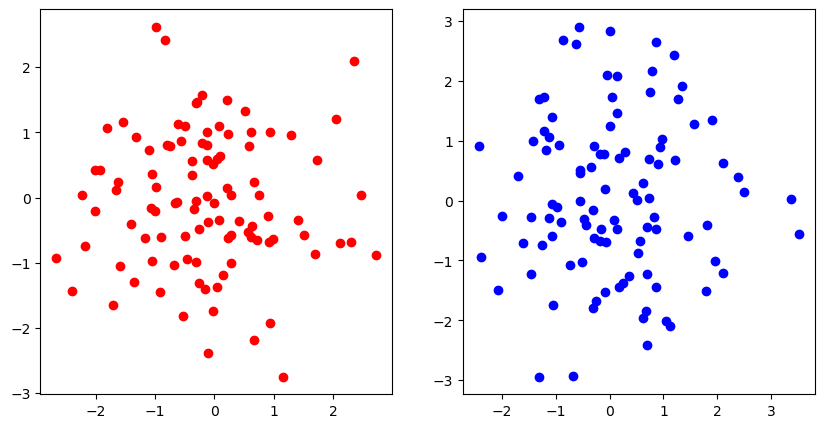

In [37]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(torch.cat(z_0)[:,0], torch.cat(z_0)[:,1], c='r')
plt.subplot(1,2,2)
plt.scatter(torch.cat(z_1)[:,0], torch.cat(z_1)[:,1], c='b')

In [41]:
x = torch.cat([x_0, x_1])
print(x.shape)

with torch.no_grad():
    x_hat = model.model(x)

model.model.bottleneck.sigma.detach(), model.model.bottleneck.mu.detach()

torch.Size([2, 1, 28, 28])


(tensor([[1.1109, 1.0648],
         [1.1691, 1.3119]]),
 tensor([[ 0.0022, -0.0050],
         [ 0.0042,  0.0061]]))

In [46]:
x, y = next(iter(test_loader))
x_0 = x[torch.argwhere(y==0).squeeze()[:200]]
x_1 = x[torch.argwhere(y==1).squeeze()[:200]]

x = torch.cat([x_0, x_1])
with torch.no_grad():
    x_hat = model.model(x)

model.model.bottleneck.sigma[:200].detach().mean(), model.model.bottleneck.sigma[200:400].detach().mean()

(tensor(1.0622), tensor(1.4040))

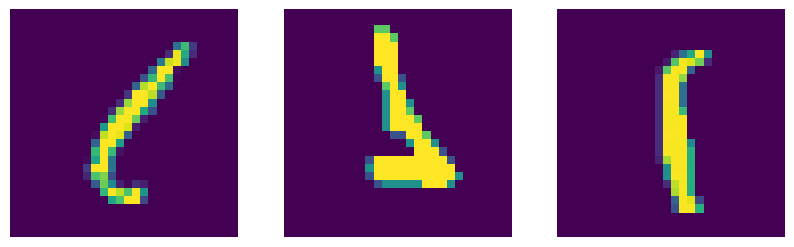

In [49]:
# Get the idx of the highest 3 sigma
idx = torch.argsort(model.model.bottleneck.sigma[:200].mean(axis=1), descending=True)
model.model.bottleneck.sigma[idx[:3]]

to_show = x[idx[:3]]
fig = plt.figure(figsize=(10,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(to_show[i,0])
    plt.axis('off')

# Reconstruction

In [53]:
import numpy as np
def plot_reconstructed(model, r0=(-6, 6), r1=(-6, 6), n=12):
    model.eval()
    w = 28
    img = np.zeros((n*w, n*w))

    fig = plt.figure(figsize=(5, 5))

    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]])
            x_hat = torch.tanh(model.decode_path(z)) # ADeLEn
            x_hat = x_hat.reshape(w, w).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    
    plt.xlabel(r'$\mathcal{N}(0, \sigma_1)$', fontsize='xx-large')
    plt.ylabel(r'$\mathcal{N}(0, \sigma_2)$', fontsize='xx-large')
    plt.tick_params(axis='both', which='major', labelsize='x-large')
    plt.imshow(img, extent=[*r0, *r1], cmap='viridis')

    return fig

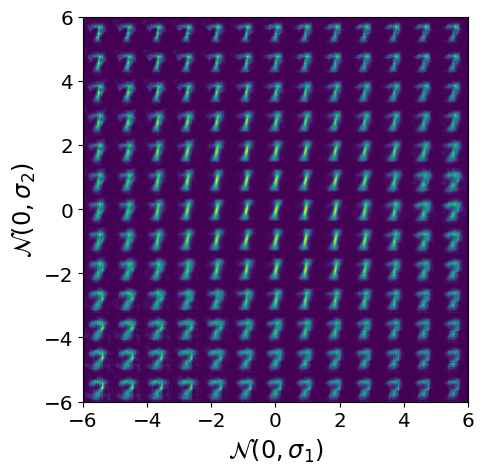

In [54]:
fig = plot_reconstructed(model.model, r0=(-6, 6), r1=(-6, 6), n=13)
# plt.savefig('figures/reconstructed.pdf', bbox_inches='tight')
plt.show(fig)

In [ ]:
# from torchvision.transforms import Normalize
# from dataset import StethoscopeAnomalyDataset
# from torch.utils.data import DataLoader

# normalize = Normalize(mean=(0.01,), std=(0.06,))
# dataset = StethoscopeAnomalyDataset(config.STETHOSCOPE_DATASET_PATH, transform=normalize)
# train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
# from model import Model

# model = LightningModel(Model(2, 3))
# trainer = pl.Trainer(max_epochs=100)
# trainer.fit(model, train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type  | Params | Mode 
----------------------------------------
0 | model | Model | 327 K  | train
1 | sgvbl | SGVBL | 327 K  | train
----------------------------------------
327 K     Trainable params
0         Non-trainable params
327 K     Total params
1.308     Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode
/home/ahguedes/Workspace/Anaconda/envs/ADeLEn/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 43:  48%|████▊     | 112/234 [00:02<00:02, 54.68it/s, v_num=0]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined